In [1]:
import argparse
from equilibrator_api import Reaction, ComponentContribution, ReactionMatcher, CompoundMatcher, ParseError, Pathway
from equilibrator_api.bounds import Bounds
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline

## Simple $\Delta G'^\circ$ calculations

In [2]:
kegg_id_to_coeff = {'C00002' : -1, 'C00001' : -1,
                    'C00008' :  1, 'C00009' :  1} # ATP + H2O = ADP + Pi
kegg_id_to_conc  = {'C00002' : 1e-3,
                    'C00009' :  1e-4,
                    'C00008' : 3e-3}
reaction = Reaction(kegg_id_to_coeff)
cc = ComponentContribution(pH=7.0, ionic_strength=0.1)
dG0_prime, dG0_uncertainty = cc.dG0_prime(reaction)

print(reaction)
dG0_prime, dG0_uncertainty = cc.dG0_prime(reaction)
print("\nΔG'° = %.2f ± %.2f [kJ/mol]" % (dG0_prime, 1.96 * dG0_uncertainty))

dGm_prime, dGm_uncertainty = cc.dGm_prime(reaction)
print("\nΔG'm = %.2f ± %.2f [kJ/mol]" % (dGm_prime, 1.96 * dGm_uncertainty))

print('\nConcentrations:')
for cid, conc in kegg_id_to_conc.items():
    print('%s : %g [M]' % (cid, conc))
dG_prime, dG_uncertainty = cc.dG_prime(reaction, kegg_id_to_conc)
print("\nΔG' = %.2f ± %.2f [kJ/mol]" % (dG_prime, 1.96 * dG_uncertainty))


C00002 + C00001 = C00008 + C00009

ΔG'° = -26.39 ± 1.19 [kJ/mol]

ΔG'm = -43.51 ± 1.19 [kJ/mol]

Concentrations:
C00002 : 0.001 [M]
C00009 : 0.0001 [M]
C00008 : 0.003 [M]

ΔG' = -46.49 ± 1.19 [kJ/mol]


The ± range represents the 95% confidence interval due to Component Contribution estimation uncertainty

## Reaction matching and $\Delta G'^\circ$ estimation

In [3]:
reaction_matcher = ReactionMatcher()

def estimate_dG0(plaintext, pH=7.0, I=0.1):
    # parse the reaction
    try:
        reaction = reaction_matcher.match(plaintext)
    except ParseError:
        print('incomplete formula')
        return
    except ValueError as e:
        print(e)
        return

    html = '<p>pH = %.2f, I = %.2f M</br>KEGG reaction: %s</br></p>' % (pH, I, reaction.write_formula())
    
    equilibrator = ComponentContribution(pH=pH, ionic_strength=I)
    
    n_e = reaction.check_half_reaction_balancing()
    if n_e is None:
        html += '<p>ERROR: reaction is not chemically balanced</p>'
    elif n_e == 0:
        dG0_prime, dG0_uncertainty = equilibrator.dG0_prime(reaction)
        html += "<h2>\u0394G\'\u00B0 = %.2f \u00B1 %.2f kJ/mol</h2>" % (dG0_prime, 1.96 * dG0_uncertainty)
        ln_RI = equilibrator.reversibility_index(reaction)
        html += '<p>ln(Reversibility Index) = %.1f</p>' % ln_RI

    else:  # treat as a half-reaction
        E0_prime_mV, E0_uncertainty = equilibrator.E0_prime(reaction)
        html += '<h2>E\'\u00B0 = %.1f \u00B1 %.1f mV</h2>' % (E0_prime_mV, E0_uncertainty)

    w = widgets.HTML(html)
    display(w)
        

In [4]:
interact(estimate_dG0,
         plaintext=widgets.Text(value='glucose = fructose', font_size=20),
         pH=widgets.FloatSlider(min=0,max=14,step=0.25,value=7),
         I=widgets.FloatSlider(min=0,max=0.5,step=0.02,value=0.1));

A Jupyter Widget

The ± range represents the 95% confidence interval due to Component Contribution estimation uncertainty

## Single metabolite search

In [5]:
compound_matcher = CompoundMatcher()
df = compound_matcher.compound_df

In [6]:
df[df.CID == 'C00031']

,CID,compound_name,lowercase_name
150,C00031,D-Glucose,d-glucose
151,C00031,Dextrose,dextrose
152,C00031,Glucose,glucose
153,C00031,Grape sugar,grape sugar
154,C00031,beta-D-Glucose,beta-d-glucose
155,C00031,alpha-D-Glucose,alpha-d-glucose
156,C00031,C00031,c00031


In [7]:
def get_closest_matches(plaintext):
    # find matching compound names
    matches = compound_matcher.match(plaintext)
    
    print(matches)
    

get_closest_matches('beta-D-glucose')

        CID   compound_name  lowercase_name  score
154  C00031  beta-D-Glucose  beta-d-glucose    1.0


In [8]:
matches = compound_matcher.match('beta-D-glucose')


In [9]:
matches.sort_values('score')

,CID,compound_name,lowercase_name,score
154,C00031,beta-D-Glucose,beta-d-glucose,1.0


## Max-min Driving Force (MDF) example

In [10]:
reactions = ['C00092 + C00006 <=> C01236 + C00005',
             'C01236 + C00001 <=> C00345',
             'C00345 + C00006 <=> C00199 + C00011 + C00005']
reactions = list(map(Reaction.parse_formula, reactions))
fluxes = [1.0, 1.0, 1.0]
dG0_r_primes = list(map(lambda rxn: rxn.dG0_prime(), reactions))
bounds = Bounds(default_lb=1e-6, default_ub=1e-2)
pp = Pathway(reactions, fluxes, dG0_r_primes, bounds=bounds)

mdf_data = pp.calc_mdf()

MDF = 28.74 kJ/mol


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


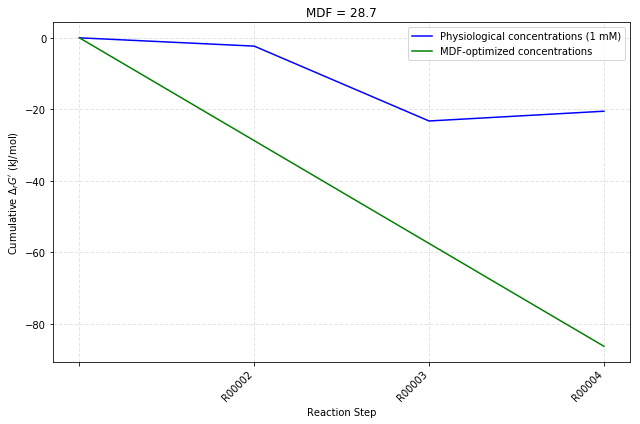

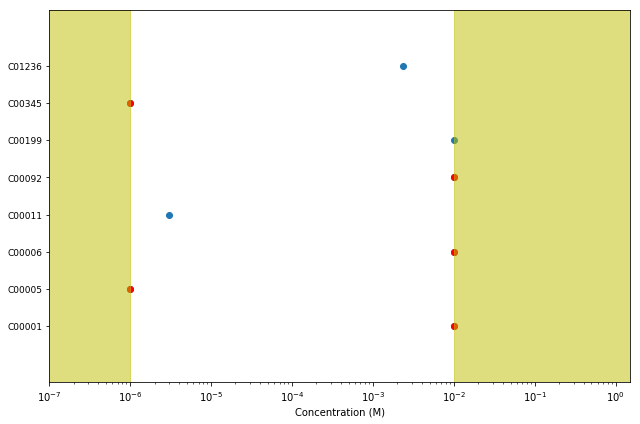

In [14]:
print('MDF = %.2f kJ/mol' % mdf_data.mdf)
fig1 = mdf_data.mdf_plot.show()
fig2 = mdf_data.conc_plot.show()